In [1]:
import matplotlib.pylab as plt
# import networkx as nx
import numpy as np
import pandas as pd
import time
import sys
import os
import textwrap

In [2]:
# preamble for jupyter notebook and django
import django
import platform

if platform.node() == "mcc-apsis":
    sys.path.append('/home/muef/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/media/Data/MCC/tmv/BasicBrowser/')

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
from parliament.tasks import do_search, run_tm
import cities.models as cmodels
from django.contrib.auth.models import User
import tmv_app.models as tm
from utils.tm_mgmt import update_topic_scores
from django.db.models import Q, Count, Func, F, Sum, Avg, Case, When, Value as V
from django.db import models

/home/finn/anaconda3/envs/textmining/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [3]:
tm.RunStats.objects.filter(psearch__title__startswith="Kohle", method='NM', K=30)


<QuerySet [<RunStats: RunStats object (44)>, <RunStats: RunStats object (43)>]>

In [3]:
K=30
method = 'NM'
search_word = "Kohle"
run_id1 = tm.RunStats.objects.get(psearch__title="{} tei utterance".format(search_word), method=method, K=K).run_id
run_id2 = tm.RunStats.objects.get(psearch__title="{} pdf utterance".format(search_word), method=method, K=K).run_id
print(run_id1)
print(run_id2)

stat1 = tm.RunStats.objects.get(pk=run_id1)
topics1 = tm.Topic.objects.filter(run_id=stat1.parent_run_id)

stat2 = tm.RunStats.objects.get(pk=run_id2)
topics2 = tm.Topic.objects.filter(run_id=stat2.parent_run_id)

43
44


In [4]:
print(topics2)

<QuerySet [<Topic: {sag, ganz, thema}>, <Topic: {kernenergi, kernkraftwerk, ausstieg}>, <Topic: {europa, union, deutsch}>, <Topic: {mensch, land, kind}>, <Topic: {klimaschutz, paris, international}>, <Topic: {erneuerbar, energi, eeg}>, <Topic: {ausschuss, drucksach, beschlussempfehl}>, <Topic: {kaltemittel, klimaanlag, grenzwert}>, <Topic: {subvention, abbau, subventionsabbau}>, <Topic: {milliard, haushalt, jahr}>, <Topic: {million, haushalt, mittel}>, <Topic: {gesetzentwurf, gesetz, anlag}>, <Topic: {ccs, technologi, ccstechnologi}>, <Topic: {pet, michael, wolfgang}>, <Topic: {region, sanier, bund}>, <Topic: {emissionshandel, zertifikat, klimaschutz}>, <Topic: {bergrecht, fracking, rohstoff}>, <Topic: {antrag, link, grun}>, <Topic: {energiew, ausbau, erneuerbar}>, <Topic: {frag, schriftlich, staatssekretarin}>, '...(remaining elements truncated)...']>


In [5]:
for i in topics1.values('id', 'top_words'):
    print("{}: {}".format(i['id'], i['top_words']))

1170: ['haushalt', 'milliard', 'jahr', 'bundeshaushalt', 'ausgab', 'bund', 'schuld', 'koalition', 'finanzpolit', 'eichel']
1169: ['klimaschutz', 'paris', 'klimawandel', 'ziel', 'deutschland', 'klimaschutzplan', 'gabriel', 'hendrick', 'mehr', 'frau']
1168: ['million', 'haushalt', 'mittel', 'einzelplan', 'euro', 'programm', 'minist', 'bereich', 'forder', 'jahr']
1167: ['forschung', 'bildung', 'innovation', 'hochschul', 'wissenschaft', 'bulmahn', 'entwickl', 'neu', 'eigenheimzulag', 'forschungspolit']
1166: ['ccs', 'technologi', 'ccstechnologi', 'speicher', 'abscheid', 'kohl', 'wirkungsgrad', 'gesetzentwurf', 'ccsgesetz', 'erprob']
1165: ['bergrecht', 'fracking', 'rohstoff', 'bergbau', 'erdgas', 'forderabgab', 'bodenschatz', 'deutschland', 'bundesberggesetz', 'interess']
1164: ['okosteu', 'okolog', 'umweltpolit', 'steuerreform', 'steu', 'rotgrun', 'belast', 'grun', 'oko', 'pfennig']
1163: ['prozent', 'jahr', 'deutschland', 'anteil', 'ziel', 'erreich', 'tonn', 'pro', 'gas', 'zahl']
1162: [

In [6]:
% matplotlib inline

# topic proportions according to party
# copied from parliament/views -> adapted for utterance
run_id = run_id1

colors = []
party_scores = []
party_names = []
norm_scores = []
topic_ids = []
topic_list = []
total_scores = []

for topic in tm.Topic.objects.filter(run_id=run_id).order_by('score'):
    # print(topic)
    s = tm.RunStats.objects.get(run_id=run_id).psearch
    party_totals = pm.Utterance.objects.filter(
        search_matches=s,
        doctopic__topic__run_id=run_id,
        speaker__party__name__isnull=False,
        speaker__party__colour__isnull=False
    ).order_by().values('speaker__party__name').annotate(
        topic_score=Sum(
            Case(
                When(doctopic__topic=topic, then=F('doctopic__score')),
                default=0,
                output_field=models.FloatField()
            )
        ),
        total_score=Sum('doctopic__score'),
    ).annotate(
        topic_proportion=F('topic_score') / F('total_score')
    ).values(
        'topic_proportion',
        'speaker__party__id',
        'speaker__party__name',
        'speaker__party__colour'
    )

    colors.append([d['speaker__party__colour'] for d in party_totals])
    party_names.append([d['speaker__party__name'] for d in party_totals])
    sc = [d['topic_proportion'] for d in party_totals]
    party_scores.append(sc)
    norm_scores.append(np.array(sc) / sum(sc))
    topic_ids.append(topic.id)
    topic_list.append(topic.top_words)
    total_scores.append(topic.score)

In [7]:
print(party_scores)
#print(party_names)
print(topic_ids)
np.array(party_scores).sum(0)

[[0.0155384937557139, 0.0148181135906938, 0.0168582515892781, 0.0247222783410919, 0.0140608930057031], [0.0217009722256484, 0.014999992345693, 0.00873400982483086, 0.0194886542796696, 0.0180044520934925], [0.0136380695255273, 0.0224880414362763, 0.0170366885672518, 0.0178020006594951, 0.0237823619137919], [0.0210268185898032, 0.0143868959860021, 0.020391802711729, 0.0378886300957556, 0.0204295659815365], [0.0226867663792906, 0.0264031524172211, 0.0153037411161663, 0.0160325897806068, 0.0318658128616597], [0.0225142932905832, 0.0224876766162632, 0.0266627503998644, 0.0251792919737003, 0.0215098756832774], [0.0234269206321628, 0.0176014401663477, 0.0232852951256239, 0.0402252938937668, 0.0275490148490967], [0.0205156389087674, 0.0169003305560752, 0.0315354035655842, 0.0288709756457769, 0.032573162136473], [0.026631076046687, 0.0473049124493496, 0.0241355585003142, 0.0185519132682021, 0.0211925468050293], [0.0190933161325922, 0.0265666294660526, 0.0285742052710146, 0.0490717771781977, 0.0

array([1., 1., 1., 1., 1.])

In [25]:
# similarly for regions of speakers
# -> this implementation is not working but should be faster, when debugged

'''
region_scores = []
topic_ids2 = []

coal_regions = cmodels.Region.objects.filter(name__in=["Brandenburg", "North Rhine-Westphalia", "Saxony"])
non_coal_regions = cmodels.Region.objects.filter(name__in=["Baden-Württemberg", "Bavaria", "Berlin", "Bremen", "Hamburg", "Hesse",
                    "Mecklenburg-Vorpommern", "Lower Saxony", "Rheinland-Pfalz",
                    "Saarland", "Saxony-Anhalt", "Schleswig-Holstein", "Thuringia"])

topics = tm.Topic.objects.filter(run_id=run_id).order_by('score')[0:2]

arrays = [range(len(topics)),
          ['direct', 'list', 'sum']]

index = pd.MultiIndex.from_product(arrays, names=['topic #', 'seat_type'])
df_regions = pd.DataFrame(index=index, columns=['coal', 'ncoal', 'top_words'])

index_to_keyword = {0: 'coal', 1: 'ncoal'}
for i, topic in enumerate(topics):
    #print(topic.top_words)
    
    region_scores_collect = []
    
    for j, regions in enumerate([coal_regions, non_coal_regions]):
        #print(list(regions))

        # differentiate between different seat types (list or direct mandate):
        # list: speaker -> seat -> partylist -> region
        ut_list = pm.Utterance.objects.filter(search_matches=s,
                            doctopic__topic__run_id=run_id,
                            speaker__seat__seat_type=2).distinct()
        ut_list = ut_list.filter(speaker__seat__list__region__in=regions)

        # direct: speaker -> seat -> consituency -> region
        ut_direct = pm.Utterance.objects.filter(search_matches=s,
                            doctopic__topic__run_id=run_id,
                            speaker__seat__seat_type=1).distinct()
        ut_direct = ut_direct.filter(speaker__seat__constituency__region__in=regions)
        ut = ut_list.union(ut_direct)

        region_score = ut.order_by().values('speaker__seat__seat_type').annotate(
                topic_score=models.Sum(
                    models.Case(
                        models.When(doctopic__topic=topic, then=models.F('doctopic__score')),
                        default=0,
                        output_field=models.FloatField()
                    )
                ),
                total_score=models.Sum('doctopic__score'),
            ).annotate(
                topic_proportion=models.F('topic_score') / models.F('total_score')
            ).values('topic_proportion')

        print(region_score)
        region_scores_collect.append(region_score)
    
    region_scores.append(region_scores_collect)
    topic_ids2.append(topic.id)
'''

'\nregion_scores = []\ntopic_ids2 = []\n\ncoal_regions = cmodels.Region.objects.filter(name__in=["Brandenburg", "North Rhine-Westphalia", "Saxony"])\nnon_coal_regions = cmodels.Region.objects.filter(name__in=["Baden-Württemberg", "Bavaria", "Berlin", "Bremen", "Hamburg", "Hesse",\n                    "Mecklenburg-Vorpommern", "Lower Saxony", "Rheinland-Pfalz",\n                    "Saarland", "Saxony-Anhalt", "Schleswig-Holstein", "Thuringia"])\n\ntopics = tm.Topic.objects.filter(run_id=run_id).order_by(\'score\')[0:2]\n\narrays = [range(len(topics)),\n          [\'direct\', \'list\', \'sum\']]\n\nindex = pd.MultiIndex.from_product(arrays, names=[\'topic #\', \'seat_type\'])\ndf_regions = pd.DataFrame(index=index, columns=[\'coal\', \'ncoal\', \'top_words\'])\n\nindex_to_keyword = {0: \'coal\', 1: \'ncoal\'}\nfor i, topic in enumerate(topics):\n    #print(topic.top_words)\n    \n    region_scores_collect = []\n    \n    for j, regions in enumerate([coal_regions, non_coal_regions]):\n  

In [11]:
# this implementation is working but really slow
# because it makes queries to the database for every topic and region separately

recalc = True

if recalc:

    coal_regions = cmodels.Region.objects.filter(name__in=["Brandenburg", "North Rhine-Westphalia", "Saxony", "Saxony-Anhalt"])
    non_coal_regions = cmodels.Region.objects.filter(name__in=["Baden-Württemberg", "Bavaria", "Berlin",
                        "Bremen", "Hamburg", "Hesse",
                        "Mecklenburg-Vorpommern", "Lower Saxony", "Rheinland-Pfalz",
                        "Saarland", "Schleswig-Holstein", "Thuringia"])

    topics = tm.Topic.objects.filter(run_id=run_id).order_by('score')
    seat_types = ['direct', 'list', 'sum']
    arrays = [range(len(topics)), seat_types]

    index = pd.MultiIndex.from_product(arrays, names=['topic #', 'seat_type'])
    df_regions = pd.DataFrame(index=index, columns=['coal', 'ncoal', 'topic_id', 'top_words'])

    index_to_keyword = {0: 'coal', 1: 'ncoal'}


    for i, topic in enumerate(topics):
        print(topic.top_words)

        for j, regions in enumerate([coal_regions, non_coal_regions]):
            print(list(regions))

            region_score_list = pm.Utterance.objects.filter(
                    search_matches=s,
                    doctopic__topic__run_id=run_id,
                    speaker__seat__seat_type=2,
                    speaker__seat__list__region__in=regions
                ).distinct().order_by().values('speaker__seat__seat_type').annotate(
                    topic_score=models.Sum(
                        models.Case(
                            models.When(doctopic__topic=topic, then=models.F('doctopic__score')),
                            default=0,
                            output_field=models.FloatField()
                        )
                    ),
                    total_score=models.Sum('doctopic__score'),
                ).annotate(
                    topic_proportion=models.F('topic_score') / models.F('total_score')
                )#.values('topic_proportion')

            region_score_direct = pm.Utterance.objects.filter(
                    search_matches=s,
                    doctopic__topic__run_id=run_id,
                    speaker__seat__seat_type=1,
                    speaker__seat__constituency__region__in=regions
                ).distinct().order_by().values('speaker__seat__seat_type').annotate(
                    topic_score=models.Sum(
                        models.Case(
                            models.When(doctopic__topic=topic, then=models.F('doctopic__score')),
                            default=0,
                            output_field=models.FloatField()
                        )
                    ),
                    total_score=models.Sum('doctopic__score'),
                ).annotate(
                    topic_proportion=models.F('topic_score') / models.F('total_score')
                )#.values('topic_proportion')

            for st in seat_types:
                df_regions['top_words'][(i, st)] = topic.top_words
                df_regions['topic_id'][(i, st)] = topic.id

            df_regions[index_to_keyword[j]][(i, 'direct')] = region_score_direct[0]['topic_proportion']
            df_regions[index_to_keyword[j]][(i, 'list')] = region_score_list[0]['topic_proportion']
            total_score = region_score_list[0]['topic_proportion'] + region_score_direct[0]['topic_proportion'] / 2.
            df_regions[index_to_keyword[j]][(i, 'sum')] = total_score

            print("score list: {}".format(region_score_list[0]['topic_proportion']))
            print("score direct: {}".format(region_score_direct[0]['topic_proportion']))
            print("sum: {}".format(total_score))


['ccs', 'technologi', 'ccstechnologi', 'speicher', 'abscheid', 'kohl', 'wirkungsgrad', 'gesetzentwurf', 'ccsgesetz', 'erprob']
[<Region: Saxony-Anhalt>, <Region: Saxony>, <Region: North Rhine-Westphalia>, <Region: Brandenburg>]
score list: 0.0173505560648916
score direct: 0.0181374782196513
sum: 0.02641929517471725
[<Region: Thuringia>, <Region: Schleswig-Holstein>, <Region: Saarland>, <Region: Rheinland-Pfalz>, <Region: Lower Saxony>, <Region: Mecklenburg-Vorpommern>, <Region: Hesse>, <Region: Hamburg>, <Region: Bremen>, <Region: Berlin>, <Region: Bavaria>, <Region: Baden-Württemberg>]
score list: 0.014444903642112
score direct: 0.0126709536956378
sum: 0.0207803804899309
['wald', 'holz', 'illegal', 'landwirtschaft', 'nachhalt', 'hektar', 'forstwirtschaft', 'rohstoff', 'urwald', 'waldbesitz']
[<Region: Saxony-Anhalt>, <Region: Saxony>, <Region: North Rhine-Westphalia>, <Region: Brandenburg>]
score list: 0.0161780119394179
score direct: 0.0117304562684486
sum: 0.022043240073642202
[<Reg

score list: 0.0370219816899921
score direct: 0.0532096955827057
sum: 0.06362682948134495
[<Region: Thuringia>, <Region: Schleswig-Holstein>, <Region: Saarland>, <Region: Rheinland-Pfalz>, <Region: Lower Saxony>, <Region: Mecklenburg-Vorpommern>, <Region: Hesse>, <Region: Hamburg>, <Region: Bremen>, <Region: Berlin>, <Region: Bavaria>, <Region: Baden-Württemberg>]
score list: 0.0148854430126611
score direct: 0.019475503970278
sum: 0.0246231949978001
['energiew', 'ausbau', 'eegumlag', 'netzausbau', 'cent', 'erneuerbar', 'netz', 'jahr', 'strom', 'rosl']
[<Region: Saxony-Anhalt>, <Region: Saxony>, <Region: North Rhine-Westphalia>, <Region: Brandenburg>]
score list: 0.0195344916634915
score direct: 0.0126840955481167
sum: 0.025876539437549848
[<Region: Thuringia>, <Region: Schleswig-Holstein>, <Region: Saarland>, <Region: Rheinland-Pfalz>, <Region: Lower Saxony>, <Region: Mecklenburg-Vorpommern>, <Region: Hesse>, <Region: Hamburg>, <Region: Bremen>, <Region: Berlin>, <Region: Bavaria>, <Reg

score list: 0.0420843466090694
score direct: 0.034382912640698
sum: 0.059275802929418406
['prozent', 'jahr', 'deutschland', 'anteil', 'ziel', 'erreich', 'tonn', 'pro', 'gas', 'zahl']
[<Region: Saxony-Anhalt>, <Region: Saxony>, <Region: North Rhine-Westphalia>, <Region: Brandenburg>]
score list: 0.0407166855745182
score direct: 0.0437749504090847
sum: 0.06260416077906054
[<Region: Thuringia>, <Region: Schleswig-Holstein>, <Region: Saarland>, <Region: Rheinland-Pfalz>, <Region: Lower Saxony>, <Region: Mecklenburg-Vorpommern>, <Region: Hesse>, <Region: Hamburg>, <Region: Bremen>, <Region: Berlin>, <Region: Bavaria>, <Region: Baden-Württemberg>]
score list: 0.03806971653071
score direct: 0.0465644299930973
sum: 0.06135193152725865
['arbeitsplatz', 'unternehm', 'deutschland', 'mittelstand', 'wirtschaft', 'arbeitslos', 'mehr', 'neu', 'wachstum', 'betrieb']
[<Region: Saxony-Anhalt>, <Region: Saxony>, <Region: North Rhine-Westphalia>, <Region: Brandenburg>]
score list: 0.0376778310110723
score

In [12]:
if recalc:
    regions_data_filename = "regions_scores_{}_{}_K{}_run_id{}.csv".format(search_word, method, K, run_id)
    df_regions.to_csv(regions_data_filename)

    if os.path.isfile(regions_data_filename):
        df_regions_test = pd.read_csv(regions_data_filename, index_col=[0,1], skipinitialspace=True)
    df_regions_test

In [13]:
recalc = False
if not recalc:
    regions_data_filename = "regions_scores_{}_{}_K{}_run_id{}.csv".format(search_word, method, K, run_id)
    df_regions = pd.read_csv(regions_data_filename, index_col=[0,1], skipinitialspace=True)

In [14]:
idx = pd.IndexSlice
region_data = df_regions.loc[idx[:,'sum'],['coal','ncoal']].values
normalized_region_data = np.array([i / sum(i) for i in region_data])

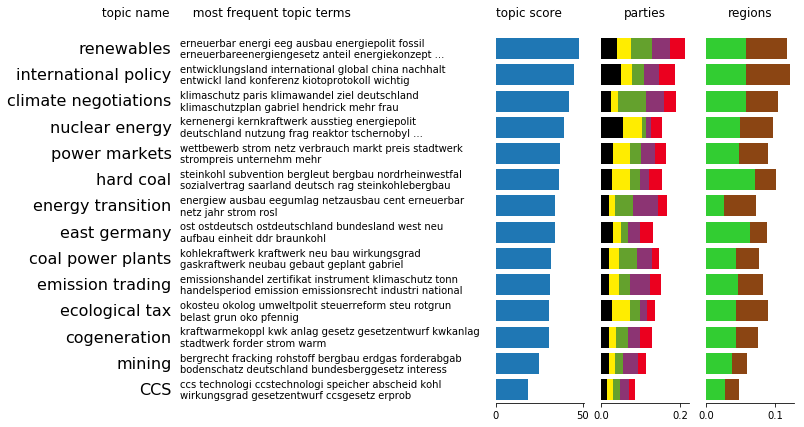

In [15]:
# plot list of topics and visualize scores for parties and regions

k = len(topic_ids)

normalized = False

# indices of topics to plot
index_list = [0,3,7,8,9,10,12,13, 14, 15, 16, 18, 22, 24]
#index_list = range(k)
plotted_topics = len(index_list)
y_pos = np.arange(plotted_topics)

if normalized:
    no_axes = 8
else:
    no_axes = 6

fig, axs = plt.subplots(1, no_axes, figsize=(no_axes*2-1,plotted_topics/2), sharey=True)

# topic description
ax = axs[0]
# numbering from 1 to ...
description_list = np.arange(k, 0, -1)
# indices
#description_list = np.arange(0, k)
# topic id in database
#description_list = np.array(topic_id)
description_list = np.flip(np.array(['renewables', 'international policy', 'climate negotiations',
                             'nuclear energy', 'power markets', 'hard coal', 'energy transition',
                            'east germany', 'coal power plants', 'emission trading', 'ecological tax',
                            'cogeneration', 'mining', 'CCS']))


box_props = dict(boxstyle='round', fc="w", ec="k")
indexed_topic_list = np.array(topic_list)[index_list]
for i, text in enumerate(description_list): #[index_list]):
    ax.text(-0.1, y_pos[i], text,
            horizontalalignment='right',
            verticalalignment='center',
           fontsize=16)
    topic_text = textwrap.fill(" ".join(indexed_topic_list[i]), width=55)
    if len(topic_text.split("\n")) > 2:
        topic_text = "\n".join(topic_text.split("\n")[0:2]) + " ..."
    text_element = ax.text(0, y_pos[i], topic_text, fontsize=10,
        verticalalignment='center', horizontalalignment='left')

ax.set_axis_off()
ax.set_title(" topic name      most frequent topic terms", loc='center')

ax = axs[1]
ax.set_axis_off()
ax = axs[2]
ax.set_axis_off()

# total scores
ax = axs[3]
patch_handles = []
ax.barh(y_pos, np.array(total_scores)[index_list], align='center')
ax.set_title("topic score", loc='left')

# party proportions
ax = axs[4]
data = np.array(party_scores)[index_list].T
plot_colors = np.array(colors)[index_list].T
patch_handles = []
left = np.zeros(plotted_topics) # left alignment of data starts at zero
for i, d in enumerate(data):
    patch_handles.append(ax.barh(y_pos, d, 
      color=plot_colors[i], align='center', 
      left=left))
    # accumulate the left-hand offsets
    left += d
ax.set_title("parties")

if normalized:
    # normalized party scores
    ax = axs[5]
    data = np.array(norm_scores)[index_list].T
    plot_colors = np.array(colors)[index_list].T
    patch_handles = []
    left = np.zeros(plotted_topics) # left alignment of data starts at zero
    for i, d in enumerate(data):
        patch_handles.append(ax.barh(y_pos, d, 
          color=plot_colors[i], align='center',
          left=left))
        # accumulate the left-hand offsets
        left += d
    ax.set_title("pp normalized")
    ax = axs[6]
else:
    ax = axs[5]

# region scores
data = np.array(region_data)[index_list].T
plot_colors = np.tile(['limegreen', 'saddlebrown'], (plotted_topics,1)).T
patch_handles = []
left = np.zeros(plotted_topics) # left alignment of data starts at zero
for i, d in enumerate(data):
    patch_handles.append(ax.barh(y_pos, d, 
      color=plot_colors[i], align='center',
      left=left))
    # accumulate the left-hand offsets
    left = left + d
ax.set_title("regions")

if normalized:
    # normalized region scores
    ax = axs[7]
    data = np.array(normalized_region_data)[index_list].T
    plot_colors = np.tile(['limegreen', 'saddlebrown'], (plotted_topics,1)).T
    patch_handles = []
    left = np.zeros(plotted_topics) # left alignment of data starts at zero
    for i, d in enumerate(data):
        patch_handles.append(ax.barh(y_pos, d, 
          color=plot_colors[i], align='center',
          left=left))
        # accumulate the left-hand offsets
        left = left + d
    ax.plot([0.5, 0.5], [-0.5, plotted_topics-0.5], 'k--')
    ax.set_title("rp normalized")
    
for ax in axs[3:no_axes]:
    ax.yaxis.set_visible(False) # Hide only x axis
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

ax.set_ylim(-0.5, plotted_topics)

fig.savefig("topic_list_{}_{}_K{}_run_id{}_new.png".format(search_word, method, K, run_id), 
            bbox_inches='tight', dpi=150)

In [ ]:
region_data.sum(0)

In [ ]:
region_data

In [ ]:
plot_colors

In [ ]:
# todo: make more efficient by requesting all data at once
party_totals = pm.Utterance.objects.filter(
    search_matches=s,
    doctopic__topic__run_id=stat,
    speaker__party__name__isnull=False,
    speaker__party__colour__isnull=False
).order_by().values('speaker__party__name').annotate(
    topic_score=Sum(
        Case(
            When(doctopic__topic=topic, then=F('doctopic__score')),
            default=0,
            output_field=models.FloatField()
        )
    ),
    total_score=Sum('doctopic__score'),
).annotate(
    topic_proportion=F('topic_score') / F('total_score')
).values(
    'topic_proportion',
    'speaker__party__id',
    'speaker__party__name',
    'speaker__party__colour'
)